In [20]:
import tweepy
import psycopg2

In [3]:
#!pip install psycopg2
#!pip install pretty

In [4]:
# titter Oauth
api_key  = "1USSCTtsm8hRdAJvAJImSpjGV";
api_secret_key  = "H8a6G4mKJ6JkdMLGVPgVB4iZIJ61a10x0ronM2953zES3kihL1";
access_token  = "1545349160-imp76YcBqBT5X2aEC6HXxBbINzUUhaMrNujSJsf";
access_token_secret  = "gq1IUcCEAv5p9x7bdcJ6LesXehhYWaepkfIJzJHsYKmuF";

In [5]:
# authorize the API Key
authentication = tweepy.OAuthHandler(api_key, api_secret_key)


# authorization to user's access token and access token secret
authentication.set_access_token(access_token, access_token_secret)


# call the api
api = tweepy.API(authentication)


In [6]:
# Streaming tweets from home timeline


public_tweet = api.home_timeline(count=5)


for tweet in public_tweet:
    print("-->",tweet.text)


--> حرب اليمن.. تحذير من السيناريو العراقي بعد "انتهاء التحالف السعودي عمليا"
#عاجل 

https://t.co/MCqmffi5j8
--> تعرف إلى المزايا التي تحمي الفئة النقدية السورية الجديدة من التزوير  
https://t.co/JNdKGAUvfl
--> AP review finds 31 police officers in 12 states are being investigated or have been charged in connection with the… https://t.co/82it6KouGR
--> YIMBY with a conscience: Meet the 26-year-old real-estate heir who wants to make affordable housing a reality in th… https://t.co/dKlYvytFNp
--> الفلكي "الزعاق":

اليوم .. أول أيام شباط الثاني .. أي بقي 13 يوماً ويدخل علينا نجم العقارب .. وأهالينا رحمهم الله ي… https://t.co/eCiK3SGdJN


In [7]:
# Streaming tweets from user timeline


#user = "AnalyticsVidhya"
user = "Furawi"
public_tweet = api.user_timeline(id=user,count=5)


for tweet in public_tweet:
    print("-->",tweet.text)


--> لجنة ازالة التمكين
--> @furawi auto truck kc
--> @furawi Kafka streaming app of twitter is up and running!
thank you @StephaneMaarek
--> @PatrickMahomes I pray you be OK
--> @Sudanese_Spt 10000 دولار


In [9]:
# Retrieve tweets using keywords
result = api.search(['covid','Covid-19','COVID-19'], lang='en', count=10)


# JSON keys
print(result[0]._json.keys())


dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])


In [14]:
# access individual attr
print(result[0].user._json)
#---------------------------------------------------------------------------------------------------------------------------------


{'id': 821876876, 'id_str': '821876876', 'name': 'Syamil', 'screen_name': 'modsya', 'location': 'BBB', 'description': '🇲🇾', 'url': 'https://t.co/v8nu5O9dUs', 'entities': {'url': {'urls': [{'url': 'https://t.co/v8nu5O9dUs', 'expanded_url': 'https://youtu.be/6QMPcbWR1kI', 'display_url': 'youtu.be/6QMPcbWR1kI', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 2326, 'friends_count': 381, 'listed_count': 33, 'created_at': 'Thu Sep 13 17:17:24 +0000 2012', 'favourites_count': 3822, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 137202, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': '

In [15]:
print(result[4].entities['hashtags'])

[]


In [30]:
# define streaming class
class MyStreamListener(tweepy.StreamListener):
    
    def __init__(self, time_limit=300):
        self.start_time = time.time()
        self.limit = time_limit
        super(MyStreamListener, self).__init__()
    
    def on_connect(self):
                print("Connected to Twitter API.")
        
    def on_status(self, status):
        
        
        # Tweet ID
        tweet_id = status.id
        
        # User ID
        user_id = status.user.id
        # Username
        username = status.user.name
        
        
        # Tweet
        if status.truncated == True:
            tweet = status.extended_tweet['full_text']
            hashtags = status.extended_tweet['entities']['hashtags']
        else:
            tweet = status.text
            hashtags = status.entities['hashtags']
        
        # Read hastags
        hashtags = read_hashtags(hashtags)            
        
        # Retweet count
        retweet_count = status.retweet_count
        # Language
        lang = status.lang
        
        
        # If tweet is not a retweet and tweet is in English
        if not hasattr(status, "retweeted_status") and lang=="en":
            # Connect to database
            dbConnect(user_id, username, tweet_id, tweet, retweet_count, hashtags)
            
        if (time.time() - self.start_time) > self.limit:
            
            print(time.time(), self.start_time, self.limit)
            return False
            
    def on_error(self, status_code):
        if status_code == 420:
            # Returning False in on_data disconnects the stream
            return False
       
    




In [31]:
# Extract hashtags
def read_hashtags(tag_list):
    hashtags = []
    for tag in tag_list:
        hashtags.append(tag['text'])
    return hashtags


In [32]:
# Table creation
commands = (# Table 1
            '''Create Table TwitterUser(User_Id BIGINT PRIMARY KEY, User_Name TEXT);''',
            # Table 2
            '''Create Table TwitterTweet(Tweet_Id BIGINT PRIMARY KEY,
                                         User_Id BIGINT,
                                         Tweet TEXT,
                                         Retweet_Count INT,
                                         CONSTRAINT fk_user
                                             FOREIGN KEY(User_Id)
                                                 REFERENCES TwitterUser(User_Id));''',
            # Table 3
            '''Create Table TwitterEntity(Id SERIAL PRIMARY KEY,
                                         Tweet_Id BIGINT,
                                         Hashtag TEXT,
                                         CONSTRAINT fk_user
                                             FOREIGN KEY(Tweet_Id)
                                                 REFERENCES TwitterTweet(Tweet_Id));''')


In [33]:
# Connection to database server
conn = psycopg2.connect(host="localhost",database="Twitter_st_db",port=5432,user="postgres",password="postgres")


In [34]:
# Create cursor to execute SQL commands
cur = conn.cursor()


# Execute SQL commands
for command in commands:
    # Create tables
    cur.execute(command)


# Close communication with server
conn.commit()
cur.close()
conn.close()


DuplicateTable: relation "twitteruser" already exists


In [35]:
# Insert Tweet data into database
def dbConnect(user_id, user_name, tweet_id, tweet, retweet_count, hashtags):
    
    conn = psycopg2.connect(host="localhost",database="Twitter_st_db",port=5432,user="postgres",password="postgres")
    
    cur = conn.cursor()


    # insert user information
    command = '''INSERT INTO TwitterUser (user_id, user_name) VALUES (%s,%s) ON CONFLICT
                 (User_Id) DO NOTHING;'''
    cur.execute(command,(user_id,user_name))


    # insert tweet information
    command = '''INSERT INTO TwitterTweet (tweet_id, user_id, tweet, retweet_count) VALUES (%s,%s,%s,%s);'''
    cur.execute(command,(tweet_id, user_id, tweet, retweet_count))
    
    # insert entity information
    for i in range(len(hashtags)):
        hashtag = hashtags[i]
        command = '''INSERT INTO TwitterEntity (tweet_id, hashtag) VALUES (%s,%s);'''
        cur.execute(command,(tweet_id, hashtag))
    
    # Commit changes
    conn.commit()
    
    # Disconnect
    cur.close()
    conn.close()


In [38]:
# Streaming tweets
import time
time.sleep(5)


myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener,
                        tweet_mode="extended")
myStream.filter(track=['Covid','covid-19'])


Connected to Twitter API.
1611500773.0668302 1611500473.0215847 300


In [46]:
#!pip install textblob
#!pip install wordcloud

In [55]:
from nltk.stem import WordNetLemmatizer
import numpy as np
from textblob import TextBlob
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
# clean tweets
def preprocess(tweet):
    
    # remove links
    tweet = re.sub(r'http\S+', '', tweet)
    # remove mentions
    tweet = re.sub("@\w+","",tweet)
    # alphanumeric and hashtags
    tweet = re.sub("[^a-zA-Z#]"," ",tweet)
    # remove multiple spaces
    tweet = re.sub("\s+"," ",tweet)
    tweet = tweet.lower()
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    sent = ' '.join([lemmatizer.lemmatize(w) for w in tweet.split() if len(lemmatizer.lemmatize(w))>3])


    return sent


In [57]:
# Connecting to the Database
def DbConnect(query):
    
    conn = psycopg2.connect(host="localhost",database="Twitter_st_db",port=5432,user="postgres",password="postgres")
    curr = conn.cursor()
    
    curr.execute(query)
    
    rows = curr.fetchall()
    
    return rows


In [59]:
# Create 
import pandas as pd
data_tweet = DbConnect("SELECT User_Id, Tweet_Id, Tweet FROM TwitterTweet;")
df_tweet = pd.DataFrame(columns=['User_Id','Tweet_Id','Clean_Tweet'])


for data in data_tweet:
    index = len(df_tweet)
    df_tweet.loc[index,'User_Id'] = data[0]
    df_tweet.loc[index,'Tweet_Id'] = data[1]
    df_tweet.loc[index,'Clean_Tweet'] = preprocess(data[2])
    
df_tweet.head()


,User_Id,Tweet_Id,Clean_Tweet
0,2188584708,1353356905234767872,over south african have probably died covid ph...
1,321012345,1353356905696161793,covid never happened would still running staff...
2,50989447,1353356906719395840,tune savage mind hear bhattacharya discus idea...
3,18197668,1353356906643992576,prayer comedian dave chappelle recently cancel...
4,553631704,1353356907801620482,banned youtube proof covid already existing ch...


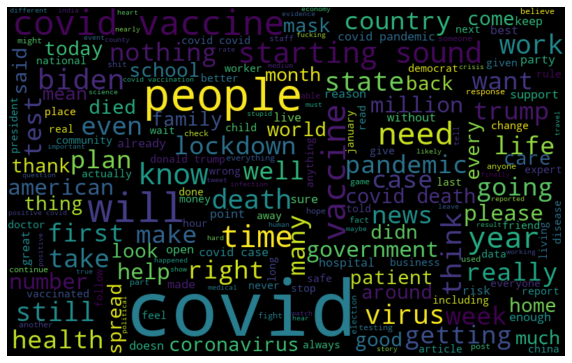

In [60]:
# Most commomly occuring words
def keywords():
    all_words = ' '.join([text for text in df_tweet['Clean_Tweet']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)


    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


keywords()


In [61]:
# Sentiment analysis using Textblob
def sentiment(tweet):


    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
df_tweet['Sentiment'] = df_tweet['Clean_Tweet'].apply(sentiment)


df_tweet.head(20)


,User_Id,Tweet_Id,Clean_Tweet,Sentiment
0,2188584708,1353356905234767872,over south african have probably died covid ph...,0
1,321012345,1353356905696161793,covid never happened would still running staff...,0
2,50989447,1353356906719395840,tune savage mind hear bhattacharya discus idea...,1
3,18197668,1353356906643992576,prayer comedian dave chappelle recently cancel...,0
4,553631704,1353356907801620482,banned youtube proof covid already existing ch...,0
5,55060090,1353356908166451200,when stephen miller first covid kept thinking ...,1
6,1287004800,1353356908279853056,covid update reported case before last week re...,0
7,767045136,1353356908497928193,your friend,0
8,67355952,1353356908887871489,tragedy huge number national guardsman covid f...,1
9,2606387688,1353356909013856257,check please restaurant grapple with confusing...,-1


In [62]:
# Querying hashtags from database
data_tags = DbConnect("SELECT Tweet_Id, Hashtag FROM TwitterEntity;")


df_tags = pd.DataFrame(columns=['Tweet_Id','Hashtags'])


for data in data_tags:
    index = len(df_tags)
    df_tags.loc[index,'Tweet_Id'] = data[0]
    df_tags.loc[index,'Hashtags'] = data[1]
    
df_tags.head(20)


,Tweet_Id,Hashtags
0,1353356910053924865,SME
1,1353356910871904257,guns
2,1353356910871904257,terrorists
3,1353356914386677760,COVID19
4,1353356914386677760,Coronavirus
5,1353356914386677760,Pandemic
6,1353356914386677760,Virginia
7,1353356915041067008,Bracknell
8,1353356917058494465,realshotinthearm
9,1353356917028999169,papworthauthors


In [63]:
# Unique hashtag counts
table = df_tags.pivot_table(index="Hashtags",values='Tweet_Id',aggfunc=len)


# Convert pivot table to dataframe
df_pivot = pd.DataFrame(table.to_records())


df_pivot.head()


,Hashtags,Tweet_Id
0,10news,1
1,1yearago,1
2,2021comeONman,1
3,AMX0035,1
4,ActuCergy,1


C:\Users\momad\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\momad\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


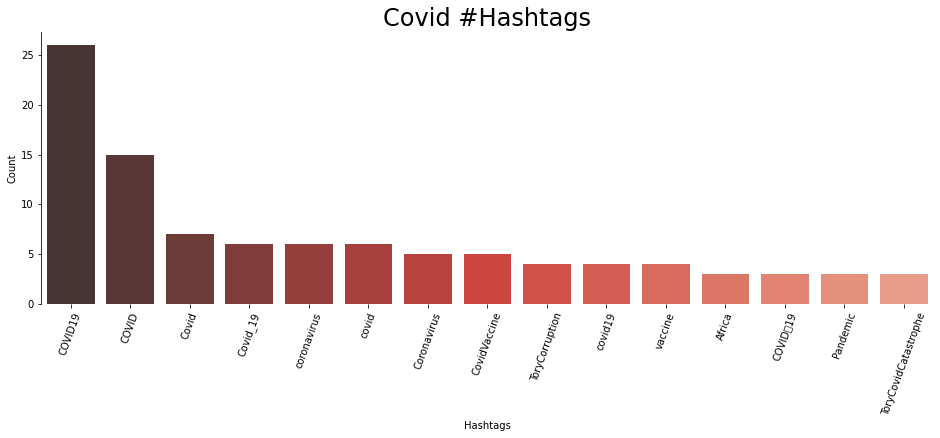

In [64]:
# Plotting hashtags counts


data = df_pivot.nlargest(columns="Tweet_Id", n = 15) 


# Creating bar graph
plt.figure(figsize=(16,5))
ax = sns.barplot(data=data, x= "Hashtags", y = "Tweet_Id", palette=("Reds_d"))


# Altering the visual elements
sns.set_context("poster")
ax.set(ylabel = 'Count')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=70)


plt.title('Covid #Hashtags')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Output plot
plt.show()
